In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random
from glob import glob
from tqdm import tqdm
from scipy.io import loadmat

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import os, sys
from typing import *
import torch
import random

In [2]:
def detach(
    batch_dict: Dict[int, List[torch.Tensor]] = None, 
    k_shot:int = None, 
    k_query:int = None
    ) -> Tuple[Dict[int, List[torch.Tensor]]]:
    sample_len = len(batch_dict[list(batch_dict.keys())[0]])
    
    if k_shot + k_query > sample_len:
        raise ValueError(f"Many data to unpack. Since #sample in support set: k_shot and #sample \
            in query set k_query must satisfy the condition: k_shot + k_query == #sample \
                in a batch per task.")
    elif k_shot + k_query < sample_len:
        raise UserWarning(f"the #sample in support set: k_shot and #sample in query set: k_query \
            totally are less than the #sample available in batch task dict. The redundant samples are \
                used in automatically used in query set.")
    
    support_dct = {
        _cls : batch_dict[_cls][:k_shot] for _cls in batch_dict
    }
    
    query_dct = {
        _cls : batch_dict[_cls][k_shot:] for _cls in batch_dict
    }
    
    return (support_dct, query_dct)

def maml_detach(
    batch_dict: Dict[int, List[torch.Tensor]] = None, 
    k_shot:int = None, 
    k_query:int = None,
    task:int = None
    ) -> Tuple[torch.Tensor]:
    
    support_dct, query_dct = detach(
        batch_dict=batch_dict,
        k_shot=k_shot,
        k_query=k_query
    )
    
    if not isinstance(task, int):
        raise ValueError(f"task arg must be integer type but found {type(task)} instead")
    elif task not in batch_dict.keys():
        raise Exception(f"Found no task {task} in batch dict")
    
    tasks = list(batch_dict.keys())
    
    support_x, support_y, query_x, query_y = [], [], [], []
    for _task in tasks:
        support_x.extend(support_dct[_task])
        query_x.extend(query_dct[_task])
        if _task == task:
            support_y.extend([1]*k_shot)
            query_y.extend([1]*k_query)
        else:
            support_y.extend([0]*k_shot)
            query_y.extend([0]*k_query)
    
    support_x = torch.stack(support_x)
    support_y = torch.FloatTensor(support_y)
    query_x = torch.stack(query_x)
    query_y = torch.FloatTensor(query_y)
    
    return (support_x, support_y, query_x, query_y)

def single_task_detach(
    batch_dict: Dict[int, List[torch.Tensor]] = None, 
    k_shot:int = None, 
    k_query:int = None,
    task:int = None
    ):
    
    support_dct, query_dct = detach(
        batch_dict=batch_dict,
        k_shot=k_shot,
        k_query=k_query
    )
    
    if not isinstance(task, int):
        raise ValueError(f"task arg must be integer type but found {type(task)} instead")
    elif task not in batch_dict.keys():
        raise Exception(f"Found no task {task} in batch dict")
    
    support_x, support_y, query_x, query_y = [], [], [], []
    
    support_x.extend(support_dct[task])
    support_y.extend([task]*len(support_dct[task]))
    query_x.extend(query_dct[task])
    query_y.extend([task]*len(query_dct[task]))
    
    support_x = torch.stack(support_x)
    support_y = torch.LongTensor(support_y)
    query_x = torch.stack(query_x)
    query_y = torch.LongTensor(query_y)
    
    return (support_x, support_y, query_x, query_y)


In [3]:
print(os.getcwd())

for i in range (3):
    os.chdir("..")
    
main_data_dir = os.getcwd() + "/Data set"

/home/thaobeo/git/HeartResearch/Experiment/Approach/Model_signal


In [4]:
data_dir = "/media/mountHDD2/khoibaocon"
print(os.listdir(data_dir))

['TrainingSet3', 'Label.csv', 'alldata', 'TrainingSet1', 'single_label.csv', 'TrainingSet2']


In [5]:
main_df = pd.read_csv(data_dir + "/Label.csv")
main_df.shape

(6877, 4)

In [6]:
main_df.head()

,Recording,First_label,Second_label,Third_label
0,A0001,5,NaN,NaN
1,A0002,1,NaN,NaN
2,A0003,2,NaN,NaN
3,A0004,2,NaN,NaN
4,A0005,7,NaN,NaN


In [7]:
main_df["First_label"].value_counts()

First_label
5    1695
2    1098
1     918
8     826
3     704
7     653
6     574
4     207
9     202
Name: count, dtype: int64

In [8]:
main_df["Second_label"].value_counts()

Second_label
5.0    162
2.0    123
7.0     47
6.0     42
8.0     41
4.0     28
3.0     18
9.0     16
Name: count, dtype: int64

In [9]:
main_df["Third_label"].value_counts()

Third_label
9.0    2
8.0    2
6.0    1
4.0    1
Name: count, dtype: int64

In [10]:
single_main_df = main_df[main_df["Second_label"].isnull()]
single_main_df.shape

(6400, 4)

In [11]:
single_main_df.to_csv(main_data_dir + "/single_label.csv")

In [12]:
mat_files = glob(data_dir + "/alldata/*")
print(len(mat_files))

6877


In [13]:
single_fns = single_main_df["Recording"].values.tolist()
print(len(single_fns))

6400


In [14]:
single_mat_paths = [data_dir + f"/alldata/{x}.mat" for x in single_fns]
print(os.path.exists(single_mat_paths[0]))

True


In [15]:
sample_data = loadmat(single_mat_paths[0])
sample_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECG'])

In [16]:
sample_signal_data = sample_data['ECG'][0][0][2]
sample_signal_data.shape

(12, 7500)

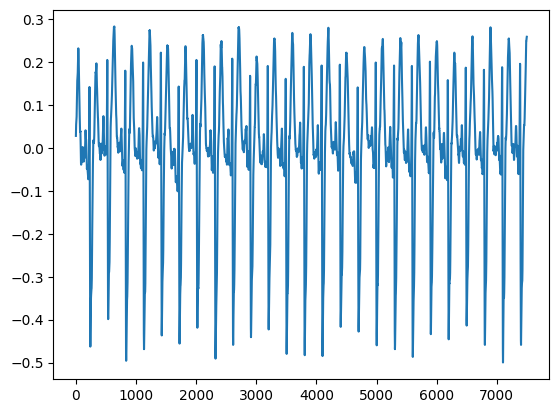

In [17]:
plt.plot(sample_signal_data[0])

In [18]:
sample_sig = torch.randn(1, 12, 32)
conv_test = nn.Conv1d(12, 12, 3, 1, 1)
print(conv_test(sample_sig).shape)

torch.Size([1, 12, 32])


In [19]:
len_lst = [loadmat(x)['ECG'][0][0][2].shape[1] for x in single_mat_paths]
print(f"MAX: {max(len_lst)}")
print(f"MIN: {min(len_lst)}")
print(f"AVG: {sum(len_lst)/len(len_lst)}")

MAX: 72000
MIN: 3000
AVG: 7946.03703125


In [32]:
class BasicBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(channel_num, channel_num, 3, padding=1),
            nn.BatchNorm1d(channel_num),
            nn.ReLU())
        
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(channel_num, channel_num, 3, padding=1),
            nn.BatchNorm1d(channel_num),
        )
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [33]:
test_basic_block = BasicBlock(2)
sample_sig = torch.randn(1, 2, 32)
print(test_basic_block(sample_sig).shape)

torch.Size([1, 2, 32])


In [34]:
class ResNet(nn.Module):
    def __init__(self, in_channels = 12, type = 18, num_classes = 9):
        super(ResNet, self).__init__()
        self.struc_dict = {
            18: {
                "num_channels" : [64, 128, 256, 512],
                "counts" : [2, 2, 2, 2]
            }
        }
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.max1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.main = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                self.struc_dict[type]["num_channels"], 
                self.struc_dict[type]["counts"]
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.main.add_module(f"conv{idx+1}_{i}", BasicBlock(num_channel))
            if idx < len(self.struc_dict[type]["num_channels"]) - 1:
                self.main.add_module(f"ext_{idx}", nn.Conv1d(num_channel, self.struc_dict[type]["num_channels"][idx+1], 3, 1))
                self.main.add_module(f"extbn_{idx}", nn.BatchNorm1d(self.struc_dict[type]["num_channels"][idx+1]))
                                     
        self.avg = torch.nn.AdaptiveAvgPool1d((1))
        self.lin = nn.Linear(self.struc_dict[type]["num_channels"][-1], num_classes)
        torch.nn.init.kaiming_normal_(self.lin.weight)
    def forward(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.main(x)
        x = self.avg(x)
        x = x.reshape(x.shape[0], -1)
        x = self.lin(x)
        return x

In [35]:
model = ResNet()
sample_sig = torch.randn(1, 12, 3000)
model(sample_sig).shape

torch.Size([1, 9])

In [36]:
# class ECG(Dataset):
#     def __init__(self, data_paths, label_df):
#         self.data_paths = data_paths
#         random.shuffle(self.data_paths)
#         self.label_df = label_df

#     def __getitem__(self, idx):
#         data_path = self.data_paths[idx]        
#         data = loadmat(data_path)['ECG'][0][0][2]
#         clip_data = data[:, 300:3000]

#         filename = data_path.split("/")[-1].split(".")[0]
#         label = self.label_df[self.label_df["Recording"] == filename]["First_label"].values.item()

#         torch_data = torch.from_numpy(clip_data)

#         return torch_data.float(), label-1

#     def __len__(self):
#         return len(self.data_paths)

In [ ]:
ks = 32
kq = 32

def set_dataset(mat_path):
    sig_dict = {_cls : [] for _cls in range(9)}    

    for data_path in mat_paths:
        filename = data_path.split("/")[-1].split(".")[0]
        _cls = single_main_df[single_main_df["Recording"] == filename]["First_label"].values.item()
        data = loadmat(data_path)['ECG'][0][0][2]
        clip_data = data[:, 300:3000]
        torch_data = torch.from_numpy(clip_data)

        sig_dict[_cls-1].append(clip_data)

    max_sample = max([len(sig_dict[_cls]) for _cls in sig_dict])
    sample_cls_cnt = max_sample + ((ks + kq) - max_sample % (ks + kq))

    a = (sample_cls_cnt/len(sig_dict[_cls]))

    for _cls in range (9):
        if a < 1:
            sig_dict = { _cls : sig_dict[_cls] + random.sample(sig_dict[_cls], k = sample_cls_cnt - len(sig_dict[_cls]))}
        else:
            sig_dict = { _cls : (int(np.floor(sample_cls_cnt/len(sig_dict[_cls]))))*sig_dict[_cls]}
            sig_dict = { _cls : sig_dict[_cls] + random.sample(sig_dict[_cls], k = sample_cls_cnt - len(sig_dict[_cls]))}
            
    return sig_dict

In [66]:
len(sig_dict[0])

1536

In [46]:
class ECG(Dataset):
    def __init__(self, dict_ds):
        self.dict_ds = dict_ds

    def __getitem__(self, idx):
        selected_dict = { _cls : self.dict_ds[_cls][index] for _cls in range(9)}

        return selected_dict

    def __len__(self):
        return len(self.dict_ds[])

In [37]:
check_ds = ECG(data_paths=single_mat_paths, label_df=single_main_df)
sample, lbl = check_ds[0]
print(sample.shape, lbl)

torch.Size([12, 2700]) 5


In [38]:
model(sample.unsqueeze(dim=0)).shape

torch.Size([1, 9])

In [39]:
data_dict = {
    idx : [] for idx in range(9)
}

for data_path in single_mat_paths:
    filename = data_path.split("/")[-1].split(".")[0]
    _cls = single_main_df[single_main_df["Recording"] == filename]["First_label"].values.item()

    data_dict[_cls-1].append(data_path)

for key in data_dict:
    print(f"{key}->{len(data_dict[key])}")

0->918
1->976
2->686
3->179
4->1533
5->532
6->607
7->784
8->185


In [40]:
train_data_dict = {
    _cls : data_dict[_cls][:int(0.9*len(data_dict[_cls]))] for _cls in data_dict
}

valid_data_dict = {
    _cls : data_dict[_cls][int(0.9*len(data_dict[_cls])):] for _cls in data_dict
}

for key in train_data_dict:
    print(f"{key}->{len(train_data_dict[key])}--{len(valid_data_dict[key])}")

0->826--92
1->878--98
2->617--69
3->161--18
4->1379--154
5->478--54
6->546--61
7->705--79
8->166--19


In [41]:
train_data_paths = []
for key in train_data_dict:
    train_data_paths.extend(train_data_dict[key])
valid_data_paths = []
for key in valid_data_dict:
    valid_data_paths.extend(valid_data_dict[key])
print(len(train_data_paths))
print(len(valid_data_paths))

5756
644


In [47]:
sig_dict = {
    idx : [] for idx in range(9)
}    

for data_path in single_mat_paths:
    filename = data_path.split("/")[-1].split(".")[0]
    _cls = single_main_df[single_main_df["Recording"] == filename]["First_label"].values.item()
    data = loadmat(data_path)['ECG'][0][0][2]
    sig_dict[_cls-1].append(data)

In [51]:
print(sig_dict[0][0].shape)

(12, 5000)


In [42]:
train_ds = ECG(train_data_paths, single_main_df)
valid_ds = ECG(valid_data_paths, single_main_df)

print(len(train_ds))
print(len(valid_ds))

5756
644


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)
batch_size = 32

traindl = DataLoader(
    train_ds,
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

validdl = DataLoader(
    valid_ds,
    batch_size=1, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

print(len(traindl))
print(len(validdl))

180
644


In [44]:
epoch = 100
lr = 0.0001
inner_epoch = 100

model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epoch)
loss_fn = nn.CrossEntropyLoss()

In [161]:
for e in range(epoch):
    model.train()
    print(f"Epoch: {e}")
    batch_cnt = 0
    total_loss = 0
    correct = 0
    for batch, (train_sig, train_data_dict) in tqdm(enumerate(traindl)):
        
        for task in train_data_dict:
            task_model = copy.deepcopy(model)
            task_optimizer = Adam(task_model.parameters(), lr=lr, weight_decay=1e-4)
            sp_x, sp_y, qr_x, qr_y = single_task_detach(batch_dict=train_data_dict,
                                                        k_shot=32,
                                                        k_query=32,
                                                        task=task)
        
            for in_e in range (inner_epoch):
                sp_x, sp_y = sp_x.to(device), sp_y.to(device)
                sp_logits = task_model(sp_x)
                sp_loss = loss_fn(sp_logits, sp_y)
                task_optimizer.zero_grad()
                sp_loss.backward()
                task_optimizer.step() 
                
            qr_x, qr_y = qr_x.to(device), qr_y.to(device)
            qr_logits = task_model(qr_x)
            qr_loss = loss_fn(qr_logits, qr_y)
            metaloss += qr_loss.item()
            qr_loss.backward()            

            for w_global, w_local in zip(model.parameters(), task_model.parameters()):
                if w_global.grad is None:
                    w_global.grad = w_local.grad
                else:
                    w_global.grad += w_local.grad  
        optimizer.step()
        optimizer.zero_grad()            

    global_model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        batch_count = 0
        for test_idx, (test_sigs, test_labels) in enumerate(validdl):
            batch_count = test_idx
            test_sigs = test_sigs.to(device, non_blocking=True)
            test_labels = test_labels.to(device, non_blocking=True)
            test_logits = model(test_sigs)                

            test_loss += loss_fn(test_logits, test_labels).item()
            _, predicted = test_logits.max(1)
            total += test_labels.size(0)
            correct += predicted.eq(test_labels).sum().item()

    print(f"Epoch: {epoch} - MetaLoss: {metaloss/num_task} - Test Loss: {test_loss/batch_count} - Test Acc: {100*correct/total}%") 
    

Epoch: 0


180it [00:08, 21.54it/s]

train loss: 1.2191842674543072 - train acc: 60.215427380125085



644it [00:01, 342.01it/s]

valid loss: 1.193489576425724 - valid acc: 61.49068322981367
Epoch: 1



180it [00:08, 21.60it/s]

train loss: 1.1113728774326475 - train acc: 63.429464906184855



644it [00:01, 340.01it/s]

valid loss: 1.0930871936171211 - valid acc: 64.44099378881988
Epoch: 2



180it [00:08, 21.52it/s]

train loss: 1.0170088883218817 - train acc: 66.73036831132731



644it [00:01, 346.58it/s]

valid loss: 1.0159193276765957 - valid acc: 66.77018633540372
Epoch: 3



180it [00:08, 21.41it/s]

train loss: 0.9080482456604195 - train acc: 70.34398888116748



644it [00:01, 323.64it/s]

valid loss: 0.9131319369071985 - valid acc: 69.72049689440993
Epoch: 4



180it [00:08, 21.43it/s]

train loss: 0.8108531366513428 - train acc: 73.59277275886032



644it [00:01, 327.73it/s]

valid loss: 0.8960865774456034 - valid acc: 68.94409937888199
Epoch: 5



180it [00:08, 21.44it/s]

train loss: 0.7572465277583905 - train acc: 75.05211952744962



644it [00:01, 337.39it/s]

valid loss: 0.8529946182070673 - valid acc: 72.04968944099379
Epoch: 6



180it [00:08, 21.39it/s]

train loss: 0.6991573578818551 - train acc: 77.72758860319666



644it [00:01, 334.45it/s]


valid loss: 0.89890343362997 - valid acc: 71.42857142857143
Epoch: 7


180it [00:08, 21.45it/s]

train loss: 0.6594170480134101 - train acc: 78.28353022932592



644it [00:01, 355.19it/s]

valid loss: 0.9581760890762877 - valid acc: 70.4968944099379
Epoch: 8



180it [00:08, 21.39it/s]

train loss: 0.6480723890845336 - train acc: 79.04794996525365



644it [00:01, 326.47it/s]

valid loss: 0.8897916690314391 - valid acc: 70.1863354037267
Epoch: 9



180it [00:08, 21.43it/s]

train loss: 0.61912993337522 - train acc: 80.31619179986102



644it [00:01, 345.00it/s]

valid loss: 0.8901127665841254 - valid acc: 71.73913043478261
Epoch: 10



180it [00:08, 21.38it/s]

train loss: 0.6036179305454872 - train acc: 80.68102849200834



644it [00:01, 340.46it/s]

valid loss: 0.834571241282156 - valid acc: 73.13664596273291
Epoch: 11



180it [00:08, 21.28it/s]

train loss: 0.6014086680705321 - train acc: 79.62126476719943



644it [00:01, 344.44it/s]

valid loss: 0.789757848052782 - valid acc: 74.68944099378882
Epoch: 12



180it [00:08, 21.42it/s]

train loss: 0.5676643717721854 - train acc: 81.61917998610147



644it [00:01, 345.07it/s]

valid loss: 0.7704657316518331 - valid acc: 75.0
Epoch: 13



180it [00:08, 21.42it/s]

train loss: 0.5513888642441627 - train acc: 82.17512161223071



644it [00:01, 336.91it/s]

valid loss: 0.7976105575342348 - valid acc: 74.84472049689441
Epoch: 14



180it [00:08, 21.35it/s]

train loss: 0.5173583197194105 - train acc: 82.88742182070882



644it [00:01, 344.93it/s]

valid loss: 0.7890755982840023 - valid acc: 74.53416149068323
Epoch: 15



180it [00:08, 21.35it/s]

train loss: 0.4896886247995845 - train acc: 84.36414176511467



644it [00:01, 342.52it/s]

valid loss: 0.8614605929613541 - valid acc: 73.4472049689441
Epoch: 16



180it [00:08, 21.42it/s]

train loss: 0.4724771291350519 - train acc: 84.71160528144544



644it [00:01, 339.34it/s]

valid loss: 0.8982661005908604 - valid acc: 72.67080745341616
Epoch: 17



180it [00:08, 21.43it/s]

train loss: 0.42958368760580457 - train acc: 85.94510076441973



644it [00:01, 341.94it/s]

valid loss: 0.9967525795467017 - valid acc: 71.73913043478261
Epoch: 18



180it [00:08, 21.41it/s]

train loss: 0.413516090985117 - train acc: 86.58790826963168



644it [00:01, 336.62it/s]

valid loss: 1.3842643792813307 - valid acc: 56.2111801242236
Epoch: 19



180it [00:08, 21.37it/s]

train loss: 0.4226514176782949 - train acc: 86.44892286309937



644it [00:01, 337.17it/s]

valid loss: 0.9981345504479263 - valid acc: 73.13664596273291
Epoch: 20



180it [00:08, 21.32it/s]

train loss: 0.39250740758533587 - train acc: 87.14384989576095



644it [00:01, 345.82it/s]

valid loss: 0.8363274216142099 - valid acc: 72.20496894409938
Epoch: 21



180it [00:08, 21.39it/s]

train loss: 0.38656964377817493 - train acc: 87.57817929117444



644it [00:01, 339.10it/s]

valid loss: 0.8424210242633916 - valid acc: 74.68944099378882
Epoch: 22



180it [00:08, 21.36it/s]

train loss: 0.3894054406015567 - train acc: 87.19596942321056



644it [00:01, 337.69it/s]

valid loss: 0.8348378496556836 - valid acc: 75.46583850931677
Epoch: 23



180it [00:08, 21.38it/s]

train loss: 0.362053664827813 - train acc: 88.20361362056984



644it [00:01, 338.76it/s]

valid loss: 0.8060450176062167 - valid acc: 75.0
Epoch: 24



180it [00:08, 21.22it/s]

train loss: 0.3289315264526359 - train acc: 89.10701876302987



644it [00:01, 343.60it/s]

valid loss: 0.8310469828724465 - valid acc: 73.75776397515527
Epoch: 25



180it [00:08, 21.33it/s]

train loss: 0.3201579762487438 - train acc: 89.61084086170952



644it [00:01, 325.49it/s]

valid loss: 0.8922432038026634 - valid acc: 73.91304347826086
Epoch: 26



180it [00:08, 21.25it/s]

train loss: 0.29816757325686555 - train acc: 90.09728978457262



644it [00:01, 338.80it/s]

valid loss: 0.9941214162846703 - valid acc: 72.36024844720497
Epoch: 27



180it [00:08, 21.30it/s]

train loss: 0.278530868238577 - train acc: 91.00069492703267



644it [00:01, 336.64it/s]

valid loss: 1.5741614079979482 - valid acc: 63.975155279503106
Epoch: 28



180it [00:08, 21.27it/s]

train loss: 0.2587924328263245 - train acc: 91.93884642112579



644it [00:01, 343.27it/s]

valid loss: 1.2179523947370454 - valid acc: 67.70186335403726
Epoch: 29



180it [00:08, 21.26it/s]

train loss: 0.26125905887541157 - train acc: 92.02571230020847



644it [00:01, 338.27it/s]

valid loss: 1.0356445621845345 - valid acc: 70.4968944099379
Epoch: 30



180it [00:08, 21.32it/s]

train loss: 0.2637338577951799 - train acc: 91.53926337734538



644it [00:01, 341.30it/s]

valid loss: 0.9502230782061907 - valid acc: 72.51552795031056
Epoch: 31



180it [00:08, 21.27it/s]

train loss: 0.2553098510805122 - train acc: 91.73036831132731



644it [00:01, 350.11it/s]

valid loss: 0.8719901056918554 - valid acc: 74.68944099378882
Epoch: 32



180it [00:08, 21.29it/s]

train loss: 0.22692058002316087 - train acc: 92.72063933287005



644it [00:01, 333.86it/s]

valid loss: 0.8700304283242654 - valid acc: 73.29192546583852
Epoch: 33



180it [00:08, 21.30it/s]

train loss: 0.22793354437421154 - train acc: 92.68589298123698



644it [00:01, 336.11it/s]

valid loss: 0.9000923583808504 - valid acc: 73.29192546583852
Epoch: 34



180it [00:08, 21.36it/s]

train loss: 0.23691129301513372 - train acc: 92.26893676164003



644it [00:01, 333.99it/s]

valid loss: 0.8988638788469896 - valid acc: 74.37888198757764
Epoch: 35



180it [00:08, 21.29it/s]

train loss: 0.20697073655088521 - train acc: 93.363446838082



644it [00:01, 333.88it/s]


valid loss: 1.0407632212759406 - valid acc: 72.20496894409938
Epoch: 36


180it [00:08, 21.28it/s]

train loss: 0.1741263039680666 - train acc: 94.7359277275886



644it [00:01, 347.72it/s]

valid loss: 1.195857472851632 - valid acc: 70.34161490683229
Epoch: 37



180it [00:08, 21.23it/s]

train loss: 0.17879818034405148 - train acc: 94.70118137595553



644it [00:01, 332.89it/s]

valid loss: 1.1682193907010463 - valid acc: 72.04968944099379
Epoch: 38



180it [00:08, 21.28it/s]

train loss: 0.16895561049270896 - train acc: 94.92703266157054



644it [00:01, 335.06it/s]

valid loss: 1.5150503504142048 - valid acc: 66.30434782608695
Epoch: 39



180it [00:08, 21.25it/s]

train loss: 0.18541198527679764 - train acc: 94.47533009034052



644it [00:01, 335.75it/s]

valid loss: 0.9979818316331985 - valid acc: 72.04968944099379
Epoch: 40



180it [00:08, 21.31it/s]

train loss: 0.1638103315617119 - train acc: 94.96177901320362



644it [00:01, 339.58it/s]

valid loss: 1.0245106155395591 - valid acc: 72.36024844720497
Epoch: 41



180it [00:08, 21.20it/s]

train loss: 0.188848340758981 - train acc: 94.21473245309242



644it [00:01, 345.66it/s]

valid loss: 0.9191674183366729 - valid acc: 73.75776397515527
Epoch: 42



180it [00:08, 21.24it/s]

train loss: 0.16383838622346936 - train acc: 94.78804725503822



644it [00:01, 352.74it/s]

valid loss: 0.9853141504756626 - valid acc: 74.37888198757764
Epoch: 43



180it [00:08, 21.25it/s]

train loss: 0.14602378655911824 - train acc: 95.53509381514941



644it [00:01, 353.78it/s]

valid loss: 1.0070697050000617 - valid acc: 73.91304347826086
Epoch: 44



180it [00:08, 21.34it/s]

train loss: 0.14144485267971815 - train acc: 95.81306462821404



644it [00:01, 344.62it/s]

valid loss: 0.9708263041820936 - valid acc: 72.98136645962732
Epoch: 45



180it [00:08, 21.31it/s]

train loss: 0.12955401965817592 - train acc: 96.47324530924253



644it [00:01, 342.68it/s]

valid loss: 1.0671623736352067 - valid acc: 73.91304347826086
Epoch: 46



180it [00:08, 21.24it/s]

train loss: 0.1283605791857289 - train acc: 96.14315496872828



644it [00:01, 333.40it/s]

valid loss: 1.1527585414824029 - valid acc: 72.67080745341616
Epoch: 47



180it [00:08, 21.18it/s]

train loss: 0.13114004243456617 - train acc: 96.02154273801251



644it [00:01, 354.46it/s]

valid loss: 1.4027554433768323 - valid acc: 70.65217391304348
Epoch: 48



180it [00:08, 21.34it/s]

train loss: 0.12210394511800572 - train acc: 96.49061848505906



644it [00:01, 349.07it/s]

valid loss: 1.3821919194015353 - valid acc: 72.20496894409938
Epoch: 49



180it [00:08, 21.35it/s]

train loss: 0.1210180384434718 - train acc: 96.21264767199445



644it [00:01, 327.17it/s]

valid loss: 1.3045416721539997 - valid acc: 70.80745341614907
Epoch: 50



180it [00:08, 21.26it/s]

train loss: 0.1009878127643183 - train acc: 97.09867963863795



644it [00:01, 341.30it/s]

valid loss: 1.0253988370612042 - valid acc: 72.98136645962732
Epoch: 51



180it [00:08, 21.27it/s]

train loss: 0.0984658070803521 - train acc: 97.28978457261988



644it [00:01, 333.62it/s]

valid loss: 1.0172266691558798 - valid acc: 74.06832298136646
Epoch: 52



180it [00:08, 21.22it/s]

train loss: 0.10168371967679961 - train acc: 97.01181375955524



644it [00:01, 336.87it/s]

valid loss: 1.0312753247526847 - valid acc: 73.75776397515527
Epoch: 53



180it [00:08, 21.23it/s]

train loss: 0.09997745933188074 - train acc: 97.20291869353717



644it [00:01, 329.81it/s]

valid loss: 1.062172014862646 - valid acc: 72.36024844720497
Epoch: 54



180it [00:08, 21.26it/s]

train loss: 0.10232201596857282 - train acc: 96.89020152883947



644it [00:01, 344.30it/s]

valid loss: 1.0369541717706436 - valid acc: 74.37888198757764
Epoch: 55



180it [00:08, 21.25it/s]

train loss: 0.1015262602771211 - train acc: 97.2550382209868



644it [00:01, 345.39it/s]

valid loss: 1.286235978202192 - valid acc: 66.92546583850931
Epoch: 56



180it [00:08, 21.39it/s]

train loss: 0.0812723184129296 - train acc: 97.75886031966643



644it [00:01, 335.12it/s]

valid loss: 1.27449595494706 - valid acc: 70.80745341614907
Epoch: 57



180it [00:08, 21.21it/s]

train loss: 0.08946045032863677 - train acc: 97.58512856150105



644it [00:01, 337.49it/s]

valid loss: 1.2483613728831309 - valid acc: 71.73913043478261
Epoch: 58



180it [00:08, 21.34it/s]

train loss: 0.08140527983013977 - train acc: 97.53300903405142



644it [00:01, 350.52it/s]

valid loss: 1.1321986917183897 - valid acc: 71.27329192546584
Epoch: 59



180it [00:08, 21.34it/s]

train loss: 0.1037741454172484 - train acc: 96.75121612230716



644it [00:01, 334.52it/s]

valid loss: 1.2585828019168057 - valid acc: 70.80745341614907
Epoch: 60



180it [00:08, 21.29it/s]

train loss: 0.09770843245650969 - train acc: 97.06393328700487



644it [00:01, 334.11it/s]

valid loss: 1.1375473184128524 - valid acc: 70.1863354037267
Epoch: 61



180it [00:08, 21.34it/s]

train loss: 0.09026158187413515 - train acc: 97.22029186935372



644it [00:01, 337.70it/s]

valid loss: 0.9951303100547169 - valid acc: 75.93167701863354
Epoch: 62



180it [00:08, 21.26it/s]

train loss: 0.09161932040630273 - train acc: 97.28978457261988



644it [00:01, 345.43it/s]

valid loss: 1.0966483617749878 - valid acc: 72.82608695652173
Epoch: 63



180it [00:08, 21.23it/s]

train loss: 0.0919865533974875 - train acc: 97.34190410006948



644it [00:01, 340.01it/s]

valid loss: 1.1104256477744212 - valid acc: 73.91304347826086
Epoch: 64



180it [00:08, 21.21it/s]

train loss: 0.10675307806040155 - train acc: 96.90757470465601



644it [00:01, 337.70it/s]

valid loss: 1.0865769653900903 - valid acc: 74.37888198757764
Epoch: 65



180it [00:08, 21.29it/s]

train loss: 0.10470491109998616 - train acc: 97.11605281445448



644it [00:01, 349.42it/s]

valid loss: 1.2868279825256652 - valid acc: 68.16770186335404
Epoch: 66



180it [00:08, 21.35it/s]

train loss: 0.08844111995074336 - train acc: 97.22029186935372



644it [00:01, 332.09it/s]

valid loss: 1.2826782779807795 - valid acc: 71.42857142857143
Epoch: 67



180it [00:08, 21.27it/s]

train loss: 0.06862876837157421 - train acc: 98.21056289089645



644it [00:01, 335.53it/s]

valid loss: 1.4625223761938546 - valid acc: 69.87577639751554
Epoch: 68



180it [00:08, 21.22it/s]

train loss: 0.0669737886403318 - train acc: 98.24530924252953



644it [00:01, 335.40it/s]

valid loss: 1.2732669920177726 - valid acc: 71.73913043478261
Epoch: 69



180it [00:08, 21.23it/s]

train loss: 0.07733675836996493 - train acc: 97.88047255038221



644it [00:01, 331.07it/s]

valid loss: 1.2524082838654254 - valid acc: 72.20496894409938
Epoch: 70



180it [00:08, 21.34it/s]

train loss: 0.07078051922697179 - train acc: 98.01945795691452



644it [00:01, 343.83it/s]

valid loss: 1.116340800104813 - valid acc: 73.29192546583852
Epoch: 71



180it [00:08, 21.24it/s]

train loss: 0.06825965192876549 - train acc: 97.94996525364836



644it [00:01, 339.36it/s]

valid loss: 1.111708802607358 - valid acc: 73.13664596273291
Epoch: 72



180it [00:08, 21.27it/s]

train loss: 0.07931613498471428 - train acc: 97.84572619874913



644it [00:01, 341.89it/s]

valid loss: 1.116333208623254 - valid acc: 74.06832298136646
Epoch: 73



180it [00:08, 21.25it/s]

train loss: 0.06366686912139034 - train acc: 98.33217512161224



644it [00:01, 334.20it/s]

valid loss: 1.099733335945977 - valid acc: 74.22360248447205
Epoch: 74



180it [00:08, 21.25it/s]

train loss: 0.08245896677325308 - train acc: 97.60250173731758



644it [00:01, 340.10it/s]

valid loss: 1.1164818937422514 - valid acc: 72.20496894409938
Epoch: 75



180it [00:08, 21.32it/s]

train loss: 0.07427614426250731 - train acc: 97.86309937456566



644it [00:01, 344.37it/s]

valid loss: 1.1817701505710787 - valid acc: 72.82608695652173
Epoch: 76



180it [00:08, 21.22it/s]

train loss: 0.053509638998553405 - train acc: 98.73175816539263



644it [00:01, 359.00it/s]

valid loss: 1.3970961082164188 - valid acc: 69.56521739130434
Epoch: 77



180it [00:08, 21.27it/s]

train loss: 0.04702142115380594 - train acc: 98.81862404447533



644it [00:01, 348.63it/s]

valid loss: 1.256554627470857 - valid acc: 71.8944099378882
Epoch: 78



180it [00:08, 21.30it/s]

train loss: 0.04776813924005619 - train acc: 98.73175816539263



644it [00:01, 336.56it/s]

valid loss: 1.500858809971492 - valid acc: 70.96273291925466
Epoch: 79



180it [00:08, 21.26it/s]

train loss: 0.07333766120387106 - train acc: 98.03683113273107



644it [00:01, 332.36it/s]

valid loss: 1.1644543255625308 - valid acc: 73.6024844720497
Epoch: 80



180it [00:08, 21.27it/s]

train loss: 0.035696237188030305 - train acc: 99.28769979152189



644it [00:01, 349.44it/s]

valid loss: 1.1668319409615635 - valid acc: 73.75776397515527
Epoch: 81



180it [00:08, 21.25it/s]

train loss: 0.04509534696689364 - train acc: 98.67963863794301



644it [00:01, 346.07it/s]

valid loss: 1.150634372428732 - valid acc: 73.13664596273291
Epoch: 82



180it [00:08, 21.29it/s]

train loss: 0.06814221754233098 - train acc: 98.07157748436414



644it [00:01, 335.58it/s]

valid loss: 1.22693291207556 - valid acc: 72.36024844720497
Epoch: 83



180it [00:08, 21.34it/s]

train loss: 0.09567397118769794 - train acc: 97.06393328700487



644it [00:01, 353.39it/s]

valid loss: 1.1166642759355694 - valid acc: 73.91304347826086
Epoch: 84



180it [00:08, 21.34it/s]

train loss: 0.09429373157954665 - train acc: 97.20291869353717



644it [00:01, 342.22it/s]

valid loss: 1.1440661236614613 - valid acc: 73.4472049689441
Epoch: 85



180it [00:08, 21.27it/s]

train loss: 0.07691857518430528 - train acc: 97.72411396803335



644it [00:01, 332.87it/s]

valid loss: 1.1896689755132148 - valid acc: 71.8944099378882
Epoch: 86



180it [00:08, 21.34it/s]

train loss: 0.07015662476441215 - train acc: 98.19318971507992



644it [00:01, 346.93it/s]

valid loss: 1.94441809729126 - valid acc: 62.732919254658384
Epoch: 87



180it [00:08, 21.26it/s]

train loss: 0.05674972487145296 - train acc: 98.33217512161224



644it [00:01, 338.26it/s]

valid loss: 1.3241261867702003 - valid acc: 69.87577639751554
Epoch: 88



180it [00:08, 21.34it/s]

train loss: 0.05411870618007411 - train acc: 98.76650451702571



644it [00:01, 334.10it/s]

valid loss: 1.4318781880353872 - valid acc: 71.8944099378882
Epoch: 89



180it [00:08, 21.28it/s]

train loss: 0.05512111675249173 - train acc: 98.59277275886032



644it [00:01, 339.58it/s]

valid loss: 1.2423844484343203 - valid acc: 72.67080745341616
Epoch: 90



180it [00:08, 21.24it/s]

train loss: 0.04593917141621672 - train acc: 98.59277275886032



644it [00:01, 331.30it/s]

valid loss: 1.2260108944972374 - valid acc: 72.67080745341616
Epoch: 91



180it [00:08, 21.30it/s]

train loss: 0.03956466188066374 - train acc: 99.06184850590688



644it [00:01, 347.39it/s]

valid loss: 1.2355990228500342 - valid acc: 73.91304347826086
Epoch: 92



180it [00:08, 21.21it/s]

train loss: 0.06015021010177137 - train acc: 98.34954829742877



644it [00:01, 329.48it/s]

valid loss: 1.2611433363500677 - valid acc: 72.36024844720497
Epoch: 93



180it [00:08, 21.25it/s]

train loss: 0.05032300215224897 - train acc: 98.74913134120918



644it [00:01, 336.56it/s]

valid loss: 1.2354756554714652 - valid acc: 73.13664596273291
Epoch: 94



180it [00:08, 21.28it/s]

train loss: 0.04922536943451236 - train acc: 98.50590687977763



644it [00:01, 337.48it/s]

valid loss: 1.2465283804614937 - valid acc: 73.6024844720497
Epoch: 95



180it [00:08, 21.22it/s]

train loss: 0.06871792613840844 - train acc: 98.03683113273107



644it [00:01, 333.95it/s]

valid loss: 1.3692932626210585 - valid acc: 69.72049689440993
Epoch: 96



180it [00:08, 21.27it/s]

train loss: 0.05403696255974326 - train acc: 98.59277275886032



644it [00:01, 337.01it/s]

valid loss: 1.633410301048647 - valid acc: 71.42857142857143
Epoch: 97



180it [00:08, 21.20it/s]

train loss: 0.04799698740139853 - train acc: 98.69701181375954



644it [00:01, 343.48it/s]

valid loss: 1.5226720733256416 - valid acc: 66.30434782608695
Epoch: 98



180it [00:08, 21.22it/s]

train loss: 0.04348499441126559 - train acc: 98.69701181375954



644it [00:01, 341.10it/s]

valid loss: 1.5898940387113303 - valid acc: 73.4472049689441
Epoch: 99



180it [00:08, 21.23it/s]

train loss: 0.04844276675064762 - train acc: 98.47116052814454



644it [00:01, 352.03it/s]

valid loss: 1.2057398445076515 - valid acc: 74.84472049689441


In [ ]:
#         batch_cnt = batch
#         train_sig = train_sig.to(device)
#         train_label = train_label.to(device)
        
#         pred = model(train_sig)
#         loss = loss_fn(pred, train_label)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         scheduler.step()
        
#         total_loss += loss.item()
#         correct += (pred.argmax(1) == train_label).type(torch.float).sum().item()
    
#     total_loss /= batch_cnt
#     correct /= len(traindl.dataset)
    
#     print(f"train loss: {total_loss} - train acc: {100*correct}")
    
#     batch_cnt = 0
#     val_total_loss = 0
#     val_correct = 0
#     model.eval()
#     with torch.no_grad():
#         for batch, (valid_sig, valid_label) in tqdm(enumerate(validdl)):
#             batch_cnt = batch
#             valid_sig = valid_sig.to(device)
#             valid_label = valid_label.to(device)
            
#             pred = model(valid_sig)
#             loss = loss_fn(pred, valid_label)
            
#             val_total_loss += loss.item()
#             val_correct += (pred.argmax(1) == valid_label).type(torch.float).sum().item()
    
#         val_total_loss /= batch_cnt
#         val_correct /= len(validdl.dataset)
        
#         print(f"valid loss: {val_total_loss} - valid acc: {100*val_correct}")